In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0
Running on TPU  ['10.106.67.34:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.106.67.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.106.67.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [2]:
import numpy as np
import pandas as pd 
import os
import time
import matplotlib.pyplot as plt
print(tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

2.2.0


In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls /content/drive/'My Drive'/'Colab Notebooks'

'Chinese-English MT'   TPU_dist.ipynb   Untitled0.ipynb


In [5]:
data_dir = "/content/drive/My Drive/Colab Notebooks/Chinese-English MT"

# 构建词汇表

In [6]:

# 数据集已预处理好词汇表
def build_wordlist(path):
    word2id = {}
    id2word = {}
    with open(path, encoding = 'utf-8') as f:
        for line,word in enumerate(f):
            word2id[word.strip()] = line
            id2word[line] = word.strip()
    return word2id,id2word
    

In [7]:
word2id_zh, id2word_zh = build_wordlist(data_dir + '/vocab.zh')
word2id_en, id2word_en = build_wordlist(data_dir + '/vocab.en')

In [8]:
len(word2id_zh)

53712

In [9]:
len(word2id_en)

35028

# 构建训练集

## 统计样本长度分布

In [10]:
#统计训练样本词汇个数分布
def words_count(path):
    num_words = []
    with open(path, encoding = 'utf-8') as f:
        for line in f.readlines():
            sp = line.strip().split()
            num_words.append(len(sp))
    return num_words

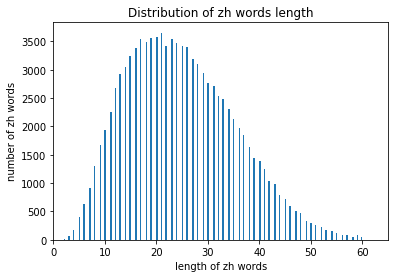

In [11]:
num_words_zh = words_count(data_dir + '/train.zh') + words_count(data_dir + '/dev.zh')

plt.hist(num_words_zh, bins=200)
plt.xlim(0, 65)
plt.ylabel("number of zh words")
plt.xlabel("length of zh words")
plt.title("Distribution of zh words length")
plt.show()

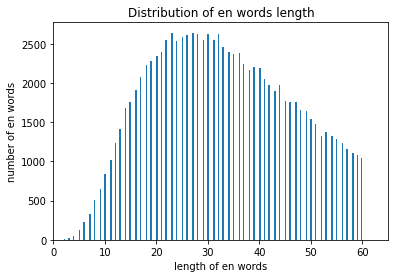

In [12]:
num_words_en = words_count(data_dir + '/train.en') + words_count(data_dir + '/dev.en')

plt.hist(num_words_en, bins=200)
plt.xlim(0, 65)
plt.ylabel("number of en words")
plt.xlabel("length of en words")
plt.title("Distribution of en words length")
plt.show()

## 训练集生成

In [13]:
max_len_en = 60
max_len_zh = 50
# 分布式训练，全局批大小
batch_size = 128
global_batch_size = batch_size * tpu_strategy.num_replicas_in_sync

In [14]:

#统计数据集大小
def data_count(path):    
    with open(path,'rb') as f:
        #统计 \n 个数（行数）
        count = 0
        while True:
            buffer = f.read(8192*1024)
            if not buffer:
                break
            count += buffer.count(bytes("\n", encoding="utf-8"))
        f.close()
        return count
    
count_train = data_count(data_dir + '/train.zh')
count_val = data_count(data_dir + '/dev.zh')
count_test = data_count(data_dir + '/test.zh')
print("训练集个数：",count_train)
print("验证集个数：",count_val)
print("测试集个数：",count_test)

训练集个数： 100000
验证集个数： 400
测试集个数： 400


In [15]:
    # 开始和结束标记
def preprocess_sentence(w):
  w = '<s> ' + w + ' </s>'
  return w

In [16]:

# 添加开始和结束标记，并填充至maxlen
def pad_data(path, mxlen, zh = 1):
    X = []
    with open(path, encoding = 'utf-8') as f:
        for line in f.readlines():
            st = line.strip('\n') #去除\n等
            w = preprocess_sentence(st) # 添加开始结束标记
            sp = w.split() # 分割为列表
            if not sp:
                continue

            x = [0] * mxlen
            # 开始标记
            index = 0
            for word in sp:
                # 控制最大长度
                if index < mxlen:
                    if zh == 1:
                        if word in word2id_zh:
                            x[index] = word2id_zh[word]
                            index += 1
                    else:
                        if word in word2id_en:
                            x[index] = word2id_en[word]
                            index += 1
                else:
                    break
            X.append(x)
    X = np.array(X)
    return X



In [17]:
train_zh = pad_data(data_dir + '/train.zh', mxlen=max_len_zh, zh = 1)
train_en = pad_data(data_dir + '/train.en', mxlen=max_len_en, zh = 0)
val_zh = pad_data(data_dir + '/dev.zh', mxlen=max_len_zh, zh = 1)
val_en = pad_data(data_dir + '/dev.en', mxlen=max_len_en, zh = 0)
test_zh = pad_data(data_dir + '/test.zh', mxlen=max_len_zh, zh = 1)
test_en = pad_data(data_dir + '/test.en', mxlen=max_len_en, zh = 0)

In [18]:
print(test_zh[0])

[    1    66    24    11    32  2535 49862     4     3   659  1469     3
  6059 14607     3  1594     4  1532   177  2071    27     4   155    28
   229   449     4   734     5     2     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [19]:
print(test_en[0])

[   1   82   36   13   11   11 2741 3756  111 7660   34    3 4512    9
    3  653    6 2140   83   60 3672 3088   13    8  113    3  672 1549
  550   17    3   62   15  186    7    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


zh2en

In [20]:
train_zh2en =  tf.data.Dataset.from_tensor_slices((train_zh, train_en)).shuffle(count_train)
# global_batch_size
train_zh2en = train_zh2en.batch(global_batch_size, drop_remainder=True)

In [21]:
val_zh2en =  tf.data.Dataset.from_tensor_slices((val_zh, val_en)).batch(global_batch_size)
# 测试集逐句
test_zh2en =  tf.data.Dataset.from_tensor_slices((test_zh, test_en))

In [22]:
# 分布式数据集
train_dataset_zh2en = tpu_strategy.experimental_distribute_dataset(train_zh2en)
val_dataset_zh2en = tpu_strategy.experimental_distribute_dataset(val_zh2en)

en2zh

In [23]:
train_en2zh =  tf.data.Dataset.from_tensor_slices((train_en, train_zh)).shuffle(count_train)
# global_batch_size
train_en2zh = train_en2zh.batch(global_batch_size, drop_remainder=True)

In [24]:
val_en2zh =  tf.data.Dataset.from_tensor_slices((val_en, val_zh)).batch(global_batch_size)
# 测试集逐句
test_en2zh =  tf.data.Dataset.from_tensor_slices((test_en, test_zh))

In [25]:
# 分布式数据集
train_dataset_en2zh = tpu_strategy.experimental_distribute_dataset(train_en2zh)
val_dataset_en2zh = tpu_strategy.experimental_distribute_dataset(val_en2zh)

# 构建模型

In [26]:
vocab_size_zh = len(word2id_zh)
vocab_size_en = len(word2id_en)

steps_per_epoch = count_train//batch_size
embedding_dim = 256
units = 1024 # GRU隐层神经元数

## 编码器

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        '''
        :vocab_size: 词汇数
        :embedding_dim: 词嵌入维度
        :enc_units: 编码器中GRU层的隐节点数
        :batch_sz: 批大小
        '''
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        '''
        embedding output:（batch size, mxlen, embedding_dim）
        gru output: (batch size, mxlen, enc_units)
        '''
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform') #均匀分布
    def call(self, x, hidden):
        x = self.embedding(x)
        # GRU输出和最后一个时间步的隐层状态
        output, state = self.gru(x, initial_state = hidden) #初始状态张量列表
        return output, state

    def initialize_hidden_state(self):
        # 隐节点零张量初始化
        return tf.zeros((self.batch_sz, self.enc_units))

## 注意力机制

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        '''
            :query为编码器的最后一时间步隐层状态：(batch size, enc_units)
            :values为编码器的所有时间步的output: (batch size, mxlen, enc_units)

            :拓展hidden维度, hidden_with_time_axis:（batch size，1，enc_units）
        '''
        
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        
        '''
            attention_weights：注意力系数
            values:(batch size, mxlen, enc_units) ==>（batch size，mxlen，dense_units）
            hidden: （batch size，1，enc_units） ==> (batch size，1，dense_units)
            Broadcasting 机制张量相加 ==>（batch size，mxlen，dense_units）
            
            score，最后一个状态state 和 mxlen个时间步隐层输出output的相似度: Dense(1) ==> (batch size，mxlen，1)
        '''

        # 对 mxlen所在维度softmax，即计算 mxlen个时间步的各自概率。概率大意味着相关性更高
        # ===> (batch size, mxlen, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 = 注意力权重 * 编码器隐层输出 【对各时间步的输出加权求和】
        context_vector = attention_weights * values
        
        # (batch size, mxlen, enc_units) ==> reduce_sum ==> (batch size, enc_units)
        # 即mxlen个时间步的对应神经元值相加（mxlen个值相加），最终去除时间步维度；为了得到神经元值
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## 解码器

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.dec_units, 
            return_sequences=True,
            return_state=True, 
            recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 使用上次隐层state计算注意力上下文，第一次使用编码器最后output
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # x : (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 将上一解码预测结果x（fc后） 和上下文向量结合作为本次GRU输入
        # (batch_size, 1, embedding_dim + enc_units)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # output: (batch_size, 1, dec_units) 单个word预测
        # state:  (batch_size, dec_units)
        output, state = self.gru(x)

        # (batch_size * 1, dec_units)
        output = tf.reshape(output, (-1, output.shape[2])) # -1代表未知

        # (batch_size, vocab_size)
        x = self.fc(output)

        return x, state, attention_weights


# 模型训练

In [30]:
with tpu_strategy.scope():

    # 中译英
    encoder_zh2en = Encoder(vocab_size_zh, embedding_dim, units, batch_size)
    decoder_zh2en = Decoder(vocab_size_en, embedding_dim, units, batch_size)

    # 英译中
    encoder_en2zh = Encoder(vocab_size_en, embedding_dim, units, batch_size)
    decoder_en2zh = Decoder(vocab_size_zh, embedding_dim, units, batch_size)



In [31]:
with tpu_strategy.scope():
    # 优化器
    optimizer = tf.keras.optimizers.Adam()

    # 损失函数
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    def loss_function(real, pred):
        # real !=0 的返回 True
        mask = tf.math.logical_not(tf.math.equal(real, 0)) 
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype) # cast类型转换
        # mask为True，即real != 0时，loss不变；否则loss为0
        loss_ *= mask
        # return tf.reduce_mean(loss_)
        return tf.nn.compute_average_loss(loss_, global_batch_size=global_batch_size)
    
    checkpoint_dir = './check'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                     encoder=encoder_zh2en,
                                     decoder=decoder_zh2en)

In [32]:
with tpu_strategy.scope():
    # 一次训练
    def train_step(inp, targ, enc_hidden, zh2en = 1):
        '''
        inp: input sequence
        targ: 翻译目标 sequence
        enc_hidden: 编码器初始state

        '''
        if zh2en == 1:
          encoder = encoder_zh2en
          decoder = decoder_zh2en
        else:
          encoder = encoder_en2zh
          decoder = decoder_en2zh

        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, enc_hidden)
            # 编码器最后一个隐层state作为解码器第一个隐层state
            dec_hidden = enc_hidden
            
            # 起始字符<s>
            # (batch_size, 1)
            dec_input = tf.expand_dims([word2id_zh['<s>']] * batch_size, 1)
            
            
            # 教师强制，将目标词作为下一个输入
            for t in range(1,targ.shape[1]):
                # x, state, attention_weights
                pre, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                if t == 1:
                  loss = loss_function(targ[:, t], pre)
                loss += loss_function(targ[:, t], pre)
                
                # 在训练时，每次解码器的输入并不是上次解码器的输出，而是样本目标语言对应单词
                dec_input = tf.expand_dims(targ[:, t], 1)

            # 所有单词的平均损失值
            # targ.shape[1] = 60或40
            batch_loss = loss / targ.shape[1]

            # 模型变量包括编码器和解码器
            variables = encoder.trainable_variables + decoder.trainable_variables

            # 计算损失函数关于自变量（模型参数）的梯度
            gradients = tape.gradient(loss, variables)
            # 根据梯度更新参数
            optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

    # 一次验证
    def val_step(inp, targ, enc_hidden, zh2en = 1):
        if zh2en == 1:
            encoder = encoder_zh2en
            decoder = decoder_zh2en
        else:
            encoder = encoder_en2zh
            decoder = decoder_en2zh

        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        # <s> 在两个词汇表索引相同
        dec_input = tf.expand_dims([word2id_zh['<s>']] * batch_size, 1)

        # 非教师强制
        for t in range(1,targ.shape[1]):
            pre, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            if t == 1:
              loss = loss_function(targ[:, t], pre)
            loss += loss_function(targ[:, t], pre)
            
            pre_argmax = tf.argmax(pre, axis = 1)
            dec_input = tf.expand_dims(pre_argmax, 1)

        # 所有单词的平均损失值
        batch_loss = loss/targ.shape[1]
        return batch_loss

    
    # TPU
    # tf.distribute.ReduceOp.SUM 将各节点放缩损失相加
    @tf.function
    def distributed_train_step(inp, targ, enc_hidden, zh2en):
        assert tf.distribute.get_replica_context() is None
        per_replica_losses = tpu_strategy.experimental_run_v2(train_step, args=(inp, targ, enc_hidden))
        return tpu_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,axis=None)

    @tf.function
    def distributed_val_step(inp, targ, enc_hidden, zh2en):
        assert tf.distribute.get_replica_context() is None
        per_replica_losses = tpu_strategy.experimental_run_v2(val_step, args=(inp, targ, enc_hidden))
        return tpu_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,axis=None)

In [33]:
with tpu_strategy.scope():
    # 批训练
    def training(zh2en):
        if zh2en == 1:
            encoder = encoder_zh2en
            decoder = decoder_zh2en
            train_dataset = train_dataset_zh2en
            val_dataset = val_dataset_zh2en
        else:
            encoder = encoder_en2zh
            decoder = decoder_en2zh
            train_dataset = train_dataset_en2zh
            val_dataset = val_dataset_en2zh

        EPOCHS = 15

        print('Start Time {}\n'.format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
        for epoch in range(EPOCHS):
            start = time.time()
            # 初始化隐藏层和损失值
            enc_hidden = encoder.initialize_hidden_state()
            total_loss = 0.0

            num_batch = 0
            for inputs in train_dataset:
                inp, targ = inputs
                batch_loss = distributed_train_step(inp, targ, enc_hidden, zh2en)
                total_loss += batch_loss

                # 每50次验证集测试,并显示模型损失值
                if num_batch % 50 == 0:
                    total_val_loss = 0.0
                    for x in val_dataset:
                        inp_val, targ_val = x
                        val_loss = distributed_val_step(inp, targ, enc_hidden, zh2en)
                        total_val_loss += val_loss

                    print('Epoch {} Batch {} Training Loss {:.4f}. Validation Loss {:.4f}.'.format(
                                                                epoch + 1,
                                                                num_batch,
                                                                batch_loss,
                                                                val_loss))

                num_batch += 1
                
            # 每次迭代保存一次数据
            # checkpoint.save(file_prefix=checkpoint_prefix)

            # 显示每次迭代的损失值和消耗时间
            print('Epoch {} Average  Training Loss {:.4f}. Time {} sec.\n'.format(epoch + 1,
                                                total_loss / num_batch,
                                                time.time() - start))


In [ ]:
with tpu_strategy.scope():
    training(1)

Start Time 2020-07-13 08:11:38

Instructions for updating:
renamed to `run`


Instructions for updating:
renamed to `run`


In [ ]:
with tpu_strategy.scope():
  from nltk.translate.bleu_score import sentence_bleu
  import math
  # 测试单句
  def test_step(inp, targ, zh2en = 1):
      if zh2en == 1:
            encoder = encoder_zh2en
            decoder = decoder_zh2en

            # 目标
            reference = [[id2word_en[x] for x in targ.numpy() if x != 0 and x != 2]]
            # 原句
            sentence = [id2word_zh[x] for x in inp.numpy() if x != 0]
            # 注意力图 (result,sentence)
            attention_plot = np.zeros((max_len_en, max_len_zh))

            id2word = id2word_en
      else:
            encoder = encoder_en2zh
            decoder = decoder_en2zh
            reference = [[id2word_zh[x] for x in targ.numpy() if x != 0 and x != 2]]
            sentence = [id2word_en[x] for x in inp.numpy() if x != 0]
            attention_plot = np.zeros((max_len_zh, max_len_en))
            id2word = id2word_zh

      
      
      # 翻译结果
      result = []

      # No Batch
      hidden = [tf.zeros((1, units))]
      inputs = tf.expand_dims(inp, 0)

      enc_output, enc_hidden = encoder(inputs, hidden)
      dec_hidden = enc_hidden
      dec_input = tf.expand_dims([word2id_zh['<s>']], 0)
      result.append('<s>')

      # 非教师强制
      for t in range(targ.shape[0]):
        pre, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        # 保留注意力权重用于绘制注意力图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        # 预测值对应字符记录在result
        pre_id = tf.argmax(pre[0]).numpy()
        if pre_id != 2 and pre_id != 0:
          result.append(id2word[pre_id])
        else:
          break

        # 将上次预测值作为下次输入
        dec_input = tf.expand_dims([pre_id], 0)

      bleu_1 = sentence_bleu(reference, result, weights=(1, 0, 0, 0))
      bleu_2 = sentence_bleu(reference, result, weights=(0, 1, 0, 0))
      bleu_3 = sentence_bleu(reference, result, weights=(0, 0, 1, 0))
      bleu_4 = sentence_bleu(reference, result, weights=(0, 0, 0, 1))
      bleu = math.exp(bleu_1 + bleu_2 + bleu_3 + bleu_4)

      return result, sentence, reference, bleu, attention_plot

In [ ]:
# # 下载--解压--移动字体文件
# !wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
# !unzip "simhei.zip"
# !rm "simhei.zip"
# !mv SimHei.ttf /usr/share/fonts/truetype/

In [ ]:
with tpu_strategy.scope():
  import matplotlib.ticker as ticker
  import matplotlib.font_manager as fm
  path = '/usr/share/fonts/truetype/SimHei.ttf'
  fontprop = fm.FontProperties(fname=path, size=14)

  # 绘制注意力图
  def plot_attention(attention, sentence, predicted_sentence):
      fig = plt.figure(figsize=(len(sentence)/3,len(predicted_sentence)/3))
      ax = fig.add_subplot(1, 1, 1)
      ax.matshow(attention, cmap='viridis')


      ax.set_xticklabels([''] + sentence, rotation=90, fontproperties=fontprop)
      ax.set_yticklabels([''] + predicted_sentence, fontproperties=fontprop)

      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
      plt.tight_layout()
      plt.show()

In [ ]:
with tpu_strategy.scope():
  bleus = []
  print('中译英')
  for _, (inp, targ) in enumerate(test_zh2en.take(5)):
    res, sent, tar, bleu, atten = test_step(inp, targ, zh2en = 1)
    bleus.append(bleu)
    print('原句：',sent)
    print('目标：',tar[0])
    print('结果：',res[1:])
    print('BLEU：',bleu)
    plot_attention(atten[:len(res[1:]), :len(sent)], sent, res[1:])
  print(bleus)
  # plot_attention(attentions[0][:len(results[0]), :len(sentences[0])], sentences[0], results[0])